Figure 3: Timing of shock predicting cells

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
# %matplotlib ipympl
# Fig3a = Fig(num=3, grid=(4, 4), size=(8.5, 6.5), fontsize=6, constrained_layout=False)  # size=(7.2, 5.3) if not scaling properly
# print(Fig3a.fig.get_size_inches())
# Fig3astats = Fig(num="Figure 3 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=3) 
# print(Fig3astats.fig.get_size_inches())
# Fig3acomb = FigMirror(Fig3a, Fig3astats)

In [232]:
def allmax(a):
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    if len(all_) == 1:
        return np.array(all_, dtype=int).squeeze()
    else:
        return np.around(np.mean(all_)).astype(int).squeeze()

In [233]:
def snake_plot(rasters, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
        
    peak_id = np.array([allmax(rast) for rast in rasters])
    sort_ids = np.argsort(peak_id)
    sns.heatmap(rasters[sort_ids])
    
    return ax, peak_id
    

In [234]:
def multiInterp2(x, xp, fp):
    i = np.arange(x.size)
    j = np.searchsorted(xp, x) - 1
    d = (x - xp[j]) / (xp[j + 1] - xp[j])
    return (1 - d) * fp[i, j] + fp[i, j + 1] * d

In [578]:
def freeze_group_snake_plot(group, arena, day, buffer_sec=(2, 2), sr_match=20):
    """Plot freeze-tuned cells for each group/day"""
    
    # Set up times
    times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
    
    freeze_rasts_mean = []
    srs = []
    for mouse in group:
        MD1 = fa.MotionTuning(mouse, arena, day)
        MD1.gen_pe_rasters(buffer_sec=buffer_sec)
        freeze_cells = MD1.select_cells('freeze_fine', buffer_sec=buffer_sec)
        rast_use = MD1.pe_rasters['freeze_onset'][freeze_cells]
        
        if MD1.sr_image != sr_match:  # interpolate values if sample rate doesn't match to make data compatible
            rast_mean_interp = []
            times_sr = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
            for act in rast_use.mean(axis=1):
                rast_mean_interp.append(np.interp(times, times_sr, act))
            freeze_rasts_mean.append(rast_mean_interp)
        else:
            freeze_rasts_mean.append(rast_use.mean(axis=1))

    freeze_rasts_mean_comb = np.concatenate(freeze_rasts_mean, axis=0)

#     assert np.mean(srs) == srs[0], 'Fix code to work with different sample rates'
#     times = np.arange(-buffer_sec[0], buffer_sec[1], 1/srs[0])

#     peak_id = [np.argmax(rast_mean) for rast_mean in freeze_rasts_mean_comb]
#     peak_id = np.array([allmax(rast_mean) for rast_mean in freeze_rasts_mean_comb])
#     sort_ids = np.argsort(peak_id)
#     _, ax = plt.subplots()
#     sns.heatmap(freeze_rasts_mean_comb[sort_ids])
    ax, peak_id = snake_plot(freeze_rasts_mean_comb)
    ax.set_xticks([0, int(len(times)/2), len(times)])
    ax.set_xticklabels([-buffer_sec[0], 0, buffer_sec[1]])
    print(freeze_rasts_mean_comb.shape)
    
    return ax, peak_id, times

In [ ]:
from copy import deepcopy

def add_memory_designations(df_use, before=[-2, -1], during=[4], after=[1, 2]):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df["day"] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df["day"] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df["day"] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
       # Old hardcoded method below for reference/bug checking
#     before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
#     during_ind = np.where(df["d1_d2"] == "4_1")[0]
#     after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

In [236]:
# Pre-allocate dictionary
rast_dict = {'Learners': {}, 'Non-Learners': {}, 'ANI': {}}

(347, 240)
(135, 240)
(116, 240)
(110, 240)
(107, 240)


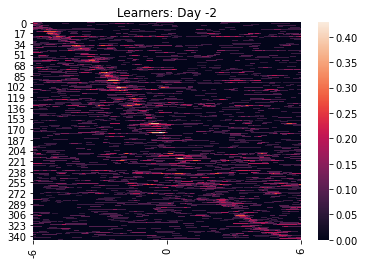

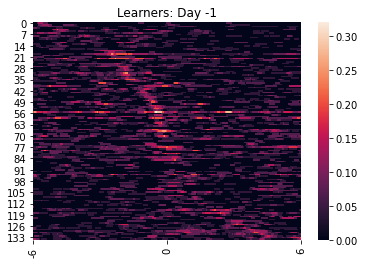

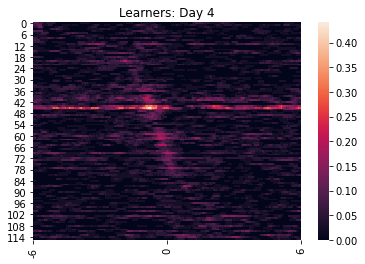

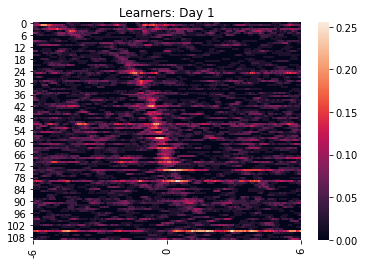

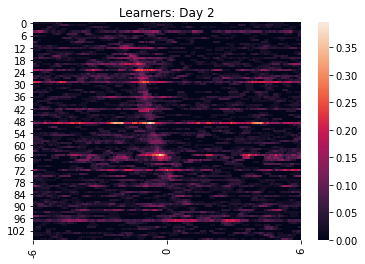

In [579]:
group, lgroup = 'Learners', err.learners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, lrn_ids, times = freeze_group_snake_plot(lgroup, arena, day, buffer_sec=(6, 6))
    rast_dict[group][day] = times[lrn_ids]
    
    ax.set_title(f'{group}: Day {day}')

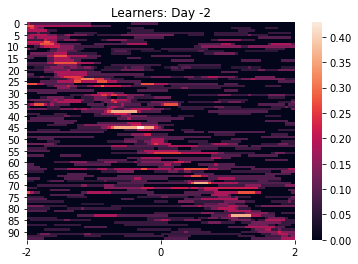

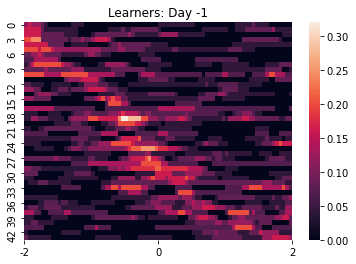

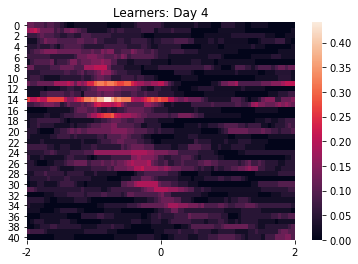

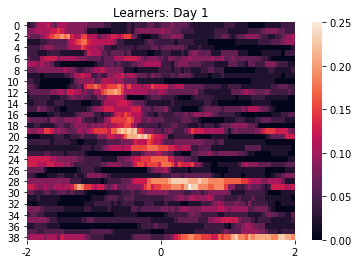

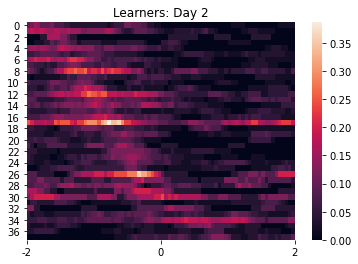

In [237]:
group, lgroup = 'Learners', err.learners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, lrn_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[lrn_ids]
    
    ax.set_title(f'{group}: Day {day}')

(450, 240)
(238, 240)
(126, 240)
(157, 240)
(163, 240)


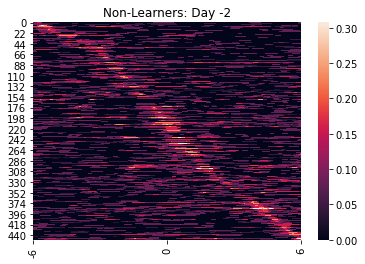

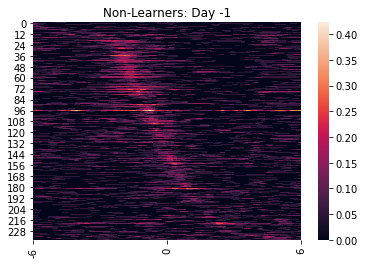

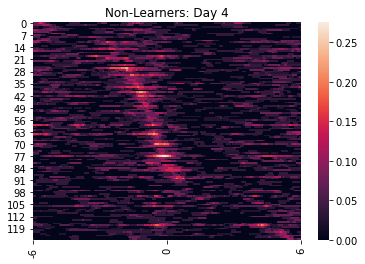

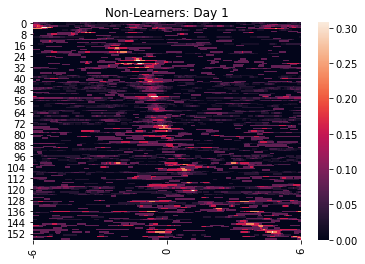

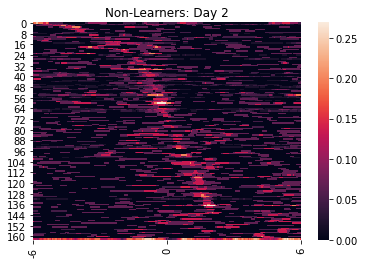

In [580]:
group, lgroup = 'Non-Learners', err.nonlearners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, nlrn_ids, times = freeze_group_snake_plot(lgroup, arena, day, buffer_sec=(6, 6))
    rast_dict[group][day] = times[nlrn_ids]
    ax.set_title(f'{group}: Day {day}')

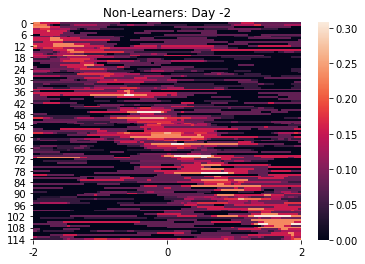

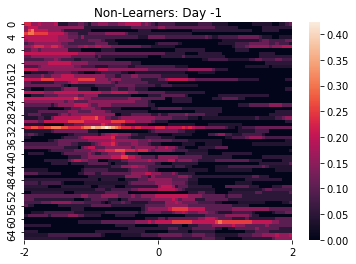

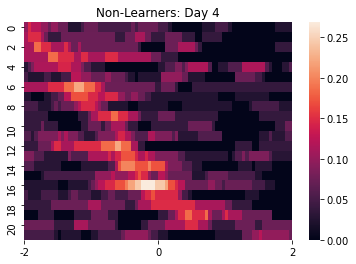

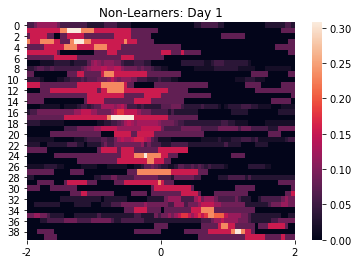

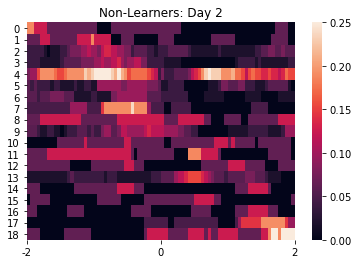

In [238]:
group, lgroup = 'Non-Learners', err.nonlearners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, nlrn_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[nlrn_ids]
    ax.set_title(f'{group}: Day {day}')

(553, 240)
(252, 240)
(104, 240)
(174, 240)
(194, 240)


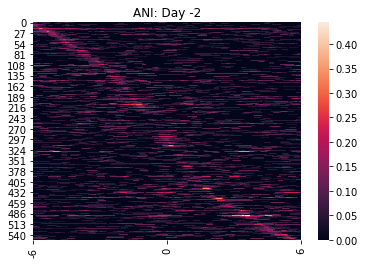

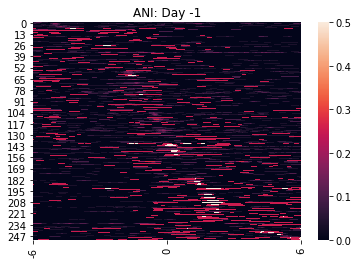

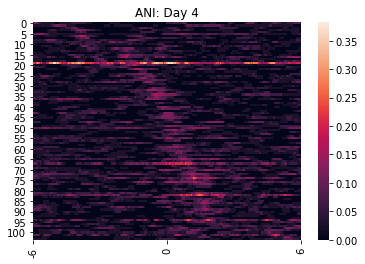

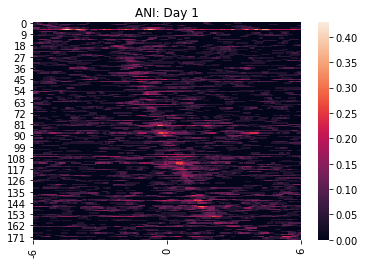

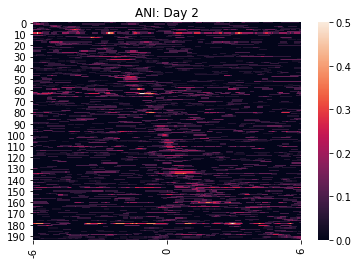

In [581]:
group, lgroup = 'ANI', err.ani_mice_good
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    ax, ani_ids, times = freeze_group_snake_plot(lgroup, arena, day, buffer_sec=(6, 6))
    rast_dict[group][day] = times[ani_ids]
    ax.set_title(f'{group}: Day {day}')

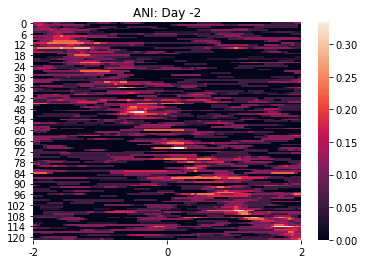

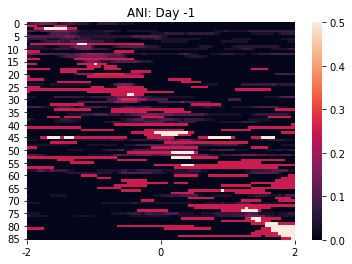

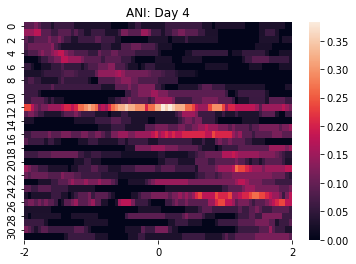

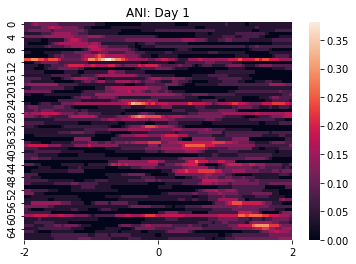

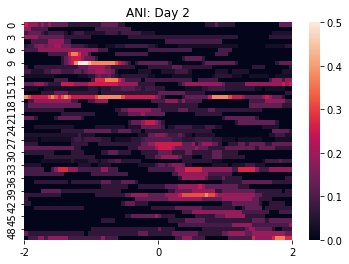

In [239]:
group, lgroup = 'ANI', err.ani_mice_good
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    ax, ani_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[ani_ids]
    ax.set_title(f'{group}: Day {day}')

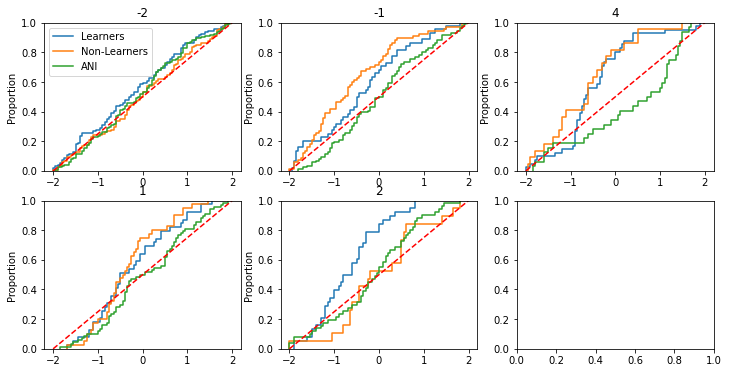

In [240]:
_, ax = plt.subplots(2, 3, figsize=(12, 6))

for a, day in zip(ax.reshape(-1), [-2, -1, 4, 1, 2]):
    for group in ['Learners', 'Non-Learners', 'ANI']:
        sns.ecdfplot(rast_dict[group][day], ax=a)
    a.plot([-2, 2], [0, 1], 'r--')
    a.set_title(str(day))

ax[0][0].legend(['Learners', 'Non-Learners', 'ANI'])

[-0.2971014492753608, -0.24697802197802043, -0.04543269230769057]
[-0.4841463414634133, -0.668181818181817, 0.32500000000000207]
[-0.4499999999999986, -0.19999999999999835, -0.004201680672267124]


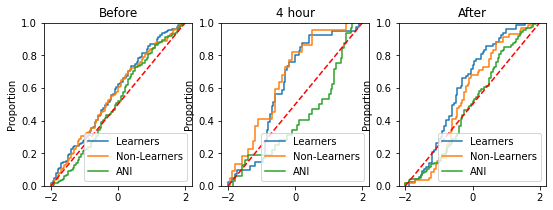

In [241]:
# Group by Before-4-After
_, ax = plt.subplots(1, 3, figsize=(9, 3))
for a, day_group, sesh_time in zip(ax.reshape(-1), [[-2, -1], [4], [1, 2]], ['Before', '4 hour', 'After']):
    means_print = []
    for group in ['Learners', 'Non-Learners', 'ANI']:
        rast_use = []
        for day in day_group:
            rast_use.append(rast_dict[group][day])
        sns.ecdfplot(np.concatenate(rast_use), ax=a)
        means_print.append(np.mean(np.concatenate(rast_use)))
    print(means_print)
    a.plot([-2, 2], [0, 1], 'r--')
    a.legend(['Learners', 'Non-Learners', 'ANI'])
    a.set_title(sesh_time)

In [ ]:
# plot mean transient event rate rasters centered on freezing

In [ ]:
%%time
# Code to generate shuffled PBE curves

MD1 = fa.MotionTuning('Marble11', 'Shock', 1)
PBEshuf = fa.shuffle_raster(MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0], MD1.select_events(event_type), 
                                   sr_image=MD1.sr_image, buffer_sec=buffer_sec_use, nperm=1000)
times = np.arange(-buffer_sec_use[0], buffer_sec_use[1], 1/MD1.sr_image)
shuf_times = np.matlib.repmat(times, 1, PBEshuf.shape[0]*PBEshuf.shape[1]).reshape(PBEshuf.shape)

In [ ]:
# This is way too slow.
%%time
PBEshuf_df = pd.DataFrame({'times': shuf_times.reshape(-1), 'act_neuron_ratio': PBEshuf.reshape(-1)})
_, ax = plt.subplots()
sns.lineplot(data=PBEshuf_df, x='times', y='act_neuron_ratio', ax=ax)
ax.plot([-6, 6], [0.0111, 0.0111], 'r--')
ax.set_ylim([0.008, 0.02])

In [ ]:
# # For debugging below
# buffer_sec = (6, 6)
# sr_match = 20
# event_type = 'freeze_onset'
# times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
# animal_list = err.ani_mice_good
# group_name = 'ANI'
# nanimals = len(animal_list)
# PBEdict = {}
# for day in  [-2, -1, 4, 1, 2]:
#     PBErast_comb, PBErast_combz, times_comb = [], [], []
#     for animal in animal_list:
#         MD1 = fa.MotionTuning(animal, 'Shock', day)
#         PBErast = fa.get_PE_raster(MD1.PSAbool.sum(axis=0), MD1.select_events(event_type), 
#                                    sr_image=MD1.sr_image, buffer_sec=buffer_sec)
#         # Sum up cells active and divide by total to get proportion active before each event
#         PBErast_prop = PBErast.mean(axis=0)/MD1.PSAbool.shape[0]
        
#         # z-score proportions
#         prop_active = MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0]
#         PBErast_propz = (PBErast_prop - prop_active.mean())/prop_active.std()
        
#         if MD1.sr_image != sr_match:  # interpolate values if sample rate doesn't match to make data compatible
#             rast_mean_interp = []
#             times_sr = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
#             PBErast_comb.extend(np.interp(times, times_sr, PBErast_prop))
#             PBErast_combz.extend(np.interp(times, times_sr, PBErast_propz))
#         else:
#             PBErast_comb.extend(PBErast_prop) 
#             PBErast_combz.extend(PBErast_propz)
#         times_comb.extend(times)  # aggregate times
        
#         PBEshuf = fa.shuffle_raster(MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0], MD1.select_events(event_type), 
#                                    sr_image=MD1.sr_image, buffer_sec=buffer_sec, nperm=1000)
        
#     # Assemble into dataframes for easy plotting later on
#     PBEdict[day] = pd.DataFrame({'times': np.array(times_comb).reshape(-1), 
#                                  'act_neuron_ratio': np.array(PBErast_comb).reshape(-1),
#                                  'act_neuron_ratio_z': np.array(PBErast_combz).reshape(-1),
#                                  'group': [group_name]*len(np.array(times_comb).reshape(-1)),
#                                  'day': [day]*len(np.array(times_comb).reshape(-1))})
        
# times = np.arange(-buffer_sec_use[0], buffer_sec_use[1], 1/MD1.sr_image)
# shuf_times = np.matlib.repmat(times, 1, PBEshuf.shape[0]*PBEshuf.shape[1]).reshape(PBEshuf.shape)

In [9]:
%%time
rast1 = MD1.pe_rasters['freeze_onset'][0]
t = np.array([np.sum(np.bitwise_and(rast1, rast2), axis=0) for rast2 in MD1.pe_rasters['freeze_onset'][1:]])
# _, ax = plt.subplots()
# sns.heatmap(t, ax=ax)
# # ax.plot(t.sum(axis=0))

CPU times: user 2.59 ms, sys: 864 µs, total: 3.46 ms
Wall time: 2.65 ms


In [27]:
MD1 = fa.MotionTuning(err.learners[-1], 'Shock', 2)
MD1.gen_pe_rasters(buffer_sec=(6, 6));

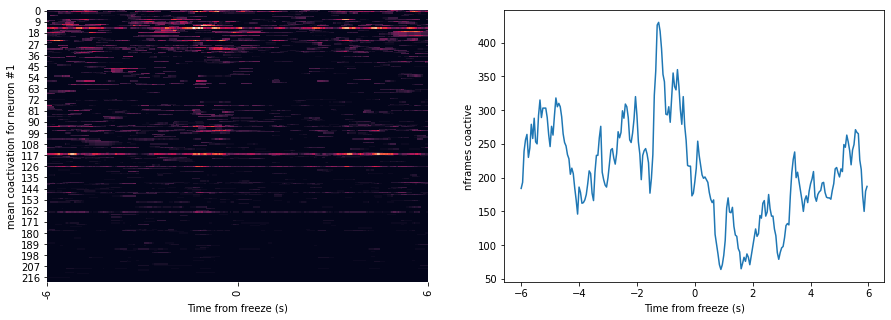

In [243]:
# Sanity check plot
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pw_co_all2, ax=ax[0], cbar=False)
ax[0].set_xticks([0, int(pw_co_all2.shape[1]/2), pw_co_all2.shape[1]])
ax[0].set_xticklabels([str(-buffer_sec[0]), "0", str(buffer_sec[1])])
ax[0].set_ylabel('mean coactivation for neuron #1')
ax[1].plot(np.arange(-6, 6, 1/20), pw_co_all2.sum(axis=0))
ax[1].set_ylabel('nframes coactive')
[a.set_xlabel('Time from freeze (s)') for a in ax];


In [164]:
%%time
# this code generates pairwise coactivity for all neuron pairs.
# MD1 = fa.MotionTuning(err.learners[-2], 'Shock', 2)
# MD1.gen_pe_rasters(buffer_sec=(6, 6))
print(MD1.pe_rasters['freeze_onset'].shape)

times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
nevents = MD1.pe_rasters['freeze_onset'][0].shape[1]
pw_co_prob_all = []
n = 1
for rast1 in MD1.pe_rasters['freeze_onset'][:-1]:

    # Sum up pairwise activity
    pw_co_prob = np.bitwise_and(rast1, MD1.pe_rasters['freeze_onset'][n:]).sum(axis=1)
    pw_co_prob_all.append(pw_co_prob)
    n += 1

(378, 43, 240)
CPU times: user 439 ms, sys: 20.5 ms, total: 459 ms
Wall time: 460 ms


In [173]:
%%time
pwt, pwprobt, timest = MD1.calc_pw_coactivity()

CPU times: user 480 ms, sys: 53.1 ms, total: 533 ms
Wall time: 538 ms


In [348]:
# Debug - why are we getting the same # of rasters?
MD1 = fa.MotionTuning('Marble07', 'Shock', 1)

# +/- 6 seconds
buffer_sec = (6, 6)
buffer_sec_filt = (6, 6)
cells_to_use = MD1.get_sig_neurons(event_type, buffer_sec=buffer_sec_filt)
print(len(cells_to_use))
                    
# Calculate coactivation
pwco, pwcoprob, times = MD1.calc_pw_coactivity(events=event_type, buffer_sec=buffer_sec, 
                                               cells_to_use=cells_to_use)

# +/- 6 second rasters but only identifying freeze cells for +/- 2 seconds
buffer_sec = (6, 6)
buffer_sec_filt = (2, 2)
cells_to_use = MD1.get_sig_neurons(event_type, buffer_sec=buffer_sec_filt)
print(len(cells_to_use))
                    
# Calculate coactivation
pwco2, pwcoprob2, times2 = MD1.calc_pw_coactivity(events=event_type, buffer_sec=buffer_sec, 
                                                  cells_to_use=cells_to_use)                               

48
calculating rasters with 48 cells
14
calculating rasters with 14 cells


/Users/nkinsky/Documents/BU/GitHub/Eraser/freezing_analysis.py:285: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cells_to_use == 'all':


In [378]:
def gen_pw_coact(event_type, arena='Shock', buffer_sec=(6, 6), buffer_sec_filt=(6, 6), sr_match=20, 
                 days = [-2, -1, 4, 1, 2], cell_filt: str in ['all', 'freeze_cells'] = 'all', **kwargs):
    """Get pairwise coactivity for all animals and fold it nicely into a dataframe for easy plotting.  'pw_co' is the
    mean # of coactivation events for all pairs. 'pw_co_prob' is the mean probability that each pair of cells is
    coactive on a given frame, e.g.  #frames coactive / # events.
    
    **kwargs goes to MotionTuning.get_sig_neurons(...)"""
    # Set up times for all PBE rasters
    times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)

    coact_df_list = []
    for animal_list, grp_name in zip((err.learners, err.nonlearners, err.ani_mice_good),
                                     ('Learners', 'Non-learners', 'ANI')):
        pw_co_all, pw_co_prob_all, times_all, day_all, grp_all, animal_all = [], [], [], [], [], []
        for idm, mouse in enumerate(animal_list):
            for day in days:
                
                # Get motion tuning curves
                MD1 = fa.MotionTuning(mouse, arena, day)
                MD1.gen_pe_rasters(buffer_sec=buffer_sec)
                
                # Grab appropriate cells
                if cell_filt == 'all':
                    cells_to_use = 'all'
                else:
                    cells_to_use = MD1.get_sig_neurons(event_type, buffer_sec=buffer_sec_filt)
                    
                # Calculate coactivation
                pwco, pwcoprob, times = MD1.calc_pw_coactivity(events=event_type, buffer_sec=buffer_sec, 
                                                               cells_to_use=cells_to_use)
                
                # Append everything into a long list
                if pwco is not None: 
                    pw_co_all.extend(pwco.mean(axis=0))
                    pw_co_prob_all.extend(pwcoprob.mean(axis=0))
                    times_all.extend(times)
                    day_all.extend([day] * len(times))
                    grp_all.extend([grp_name] * len(times))
                    animal_all.extend([idm] * len(times))

        # Make your dataframe
        coact_df = pd.DataFrame({'time': times_all, 'pw_co': pw_co_all, 'pw_co_prob': pw_co_prob_all,
                                 'day': day_all, 'group': grp_all, 'mouse': animal_all})
        coact_df_list.append(coact_df)
        
    # Concat to create final dataframe
    coact_df_all = pd.concat(coact_df_list)
    
    return coact_df_all

In [322]:
def plot_pw_coactivity(df_in, groups=[['Learners', 'Non-learners'], ['ANI']], 
                       group_names=['Control', 'ANI'], fig_suptitle=None, ax=None):
    """Plots pairwise coactivity"""
    
    assert len(group_names) == len(groups)
    
    # Set up plotting
    if ax is None:
        fig, ax = plt.subplots(3, len(groups), figsize=(5*len(groups), 9))
    else:
        fig = ax.reshape(-1)[0].figure
    
    # These shouldn't change
    periods = ['Before', '4 hr', 'After']
    days = [[-2, -1], [4], [1, 2]]
    
    # Iterate through and plot
    for arow, period, day_list in zip(ax, periods, days):
        day_bool = [df_in['day'] == day for day in day_list]
        day_bool = np.bitwise_or(day_bool[0], day_bool[1]) if len(day_bool) == 2 else day_bool[0]
        df_use = df_in[day_bool]
        for a, group, gname in zip(arow, groups, group_names):
            group_bool = [df_use['group'] == grp for grp in group]
            group_bool = np.bitwise_or(group_bool[0], group_bool[1]) if len(group_bool) == 2 else group_bool[0]
            sns.lineplot(data=df_use[group_bool], x='time', y='pw_co_prob', ax=a)
            a.set_xlabel('Time from freeze onset (s)')
            a.set_ylabel('Prob. pairwise coactivation')
            a.set_title(f'{gname}: {period}')

        # Now match y-limits
        ylims_use = (np.array([a.get_ylim() for a in arow]).reshape(-1).min(), 
                    np.array([a.get_ylim() for a in arow]).reshape(-1).max())
        [a.set_ylim(ylims_use) for a in arow];
        
    # Figure suptitle
    if fig_suptitle is not None:
        fig.suptitle(fig_suptitle)
        
    return fig, ax

In [379]:
coact_df_freeze2 = gen_pw_coact('freeze_onset', buffer_sec=(6, 6), buffer_sec_filt=(2, 2), 
                                   cell_filt='freeze_cells')
coact_df_freeze2 = add_memory_designations(coact_df_freeze2)

/Users/nkinsky/Documents/BU/GitHub/Eraser/freezing_analysis.py:286: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  rasters_use = self.pe_rasters[events]


In [542]:
coact_df_freeze6 = gen_pw_coact('freeze_onset', buffer_sec=(6, 6), buffer_sec_filt=(6, 6), 
                                cell_filt='freeze_cells')
coact_df_freeze6 = add_memory_designations(coact_df_freeze6)

/Users/nkinsky/Documents/BU/GitHub/Eraser/freezing_analysis.py:293: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  else:


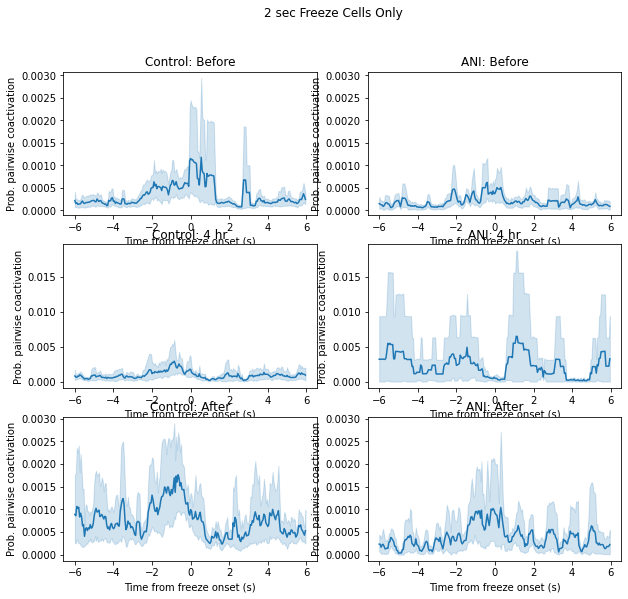

In [377]:
fig, ax = plot_pw_coactivity(coact_df_freeze2sec, groups=[['Learners', 'Non-learners'], ['ANI']], 
                             group_names=['Control', 'ANI'], fig_suptitle='2 sec Freeze Cells Only')

In [556]:
np.unique(ani_df[ani_df['Designation'] == 'During']['pw_co_prob'])

array([], dtype=float64)

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


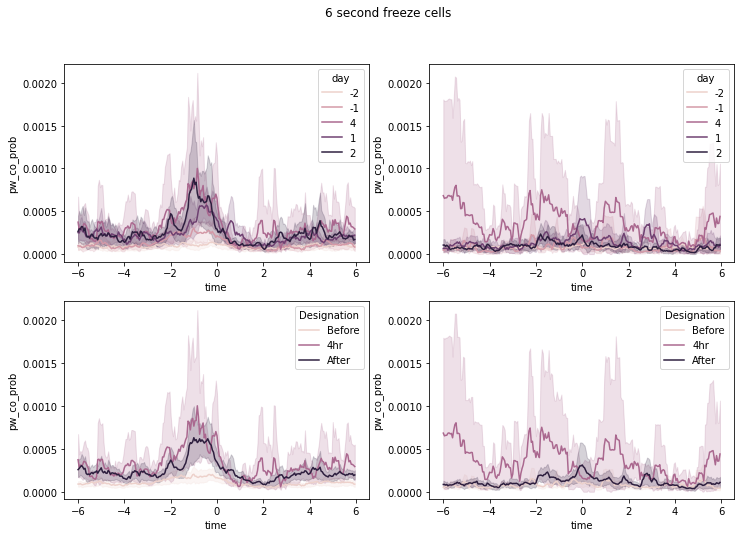

In [564]:
ctrl_df = coact_df_freeze6[(coact_df_freeze6['group'] == 'Learners') | (coact_df_freeze6['group'] == 'Non-learners')]
ctrl_df.loc[:, 'day'] = ctrl_df['day'].astype(str)  # hack to make hue_order work
ani_df = coact_df_freeze6[coact_df_freeze6['group'] == 'ANI']
ani_df.loc[:, 'day'] = ani_df['day'].astype(str)  # hack to make hue_order work
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('6 second freeze cells')
sns.lineplot(data=ctrl_df, x='time', y='pw_co_prob', hue='day', hue_order=["-2", "-1", "4", "1", "2"], 
             ax=ax[0][0], palette=sns.cubehelix_palette(n_colors=5))
sns.lineplot(data=ani_df, x='time', y='pw_co_prob', hue='day', hue_order=["-2", "-1", "4", "1", "2"], 
             ax=ax[0][1], palette=sns.cubehelix_palette(n_colors=5))
sns.lineplot(data=ctrl_df, x='time', y='pw_co_prob', hue='Designation', hue_order=["Before", "4hr", "After"], 
             ax=ax[1][0], palette=sns.cubehelix_palette(n_colors=3))
sns.lineplot(data=ani_df, x='time', y='pw_co_prob', hue='Designation', hue_order=["Before", "4hr", "After"],
             ax=ax[1][1], palette=sns.cubehelix_palette(n_colors=3))

# palette=sns.cubehelix_palette(n_colors=5) to match default behavior
[a[1].set_ylim(a[0].get_ylim()) for a in ax];

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


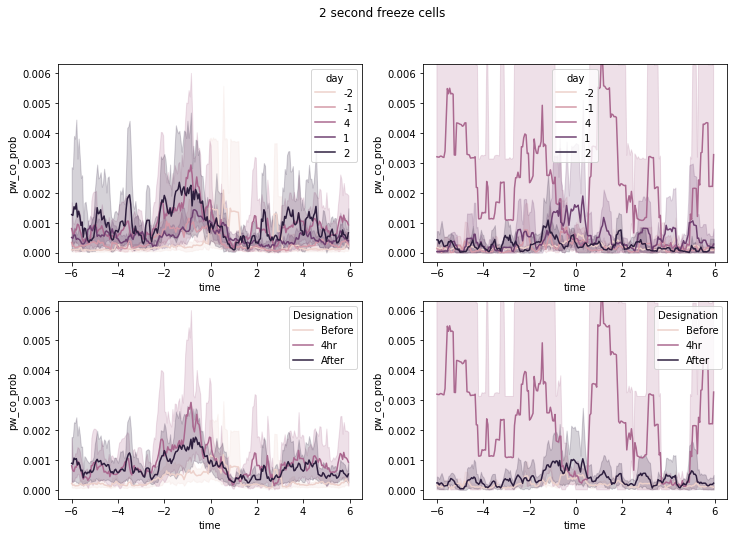

In [568]:
ctrl_df = coact_df_freeze2[(coact_df_freeze2['group'] == 'Learners') | 
                              (coact_df_freeze2['group'] == 'Non-learners')]
ctrl_df.loc[:, 'day'] = ctrl_df['day'].astype(str)  # hack to make hue_order work
ani_df = coact_df_freeze2[coact_df_freeze2['group'] == 'ANI']
ani_df.loc[:, 'day'] = ani_df['day'].astype(str)  # hack to make hue_order work
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('2 second freeze cells')
sns.lineplot(data=ctrl_df, x='time', y='pw_co_prob', hue='day', hue_order=["-2", "-1", "4", "1", "2"], 
             ax=ax[0][0], palette=sns.cubehelix_palette(n_colors=5))
sns.lineplot(data=ani_df, x='time', y='pw_co_prob', hue='day', hue_order=["-2", "-1", "4", "1", "2"], 
             ax=ax[0][1], palette=sns.cubehelix_palette(n_colors=5))
sns.lineplot(data=ctrl_df, x='time', y='pw_co_prob', hue='Designation', hue_order=["Before", "4hr", "After"], 
             ax=ax[1][0], palette=sns.cubehelix_palette(n_colors=3))
sns.lineplot(data=ani_df, x='time', y='pw_co_prob', hue='Designation', hue_order=["Before", "4hr", "After"],
             ax=ax[1][1], palette=sns.cubehelix_palette(n_colors=3))

# palette=sns.cubehelix_palette(n_colors=5) to match default behavior
[a[1].set_ylim(a[0].get_ylim()) for a in ax];

In [563]:
## NRK for above designate significant differences between groups at each time point, show that it grows significantly
# for After!

In [561]:
ani_df['Designation'].unique()

array(['Before', '4hr', 'After'], dtype=object)

In [559]:
ani_df[ani_df['Designation'] == '4 hr']

,time,pw_co,pw_co_prob,day,group,mouse,Designation


In [507]:
ctrl_df_use[ctrl_df_use['time'] == t]

,time,pw_co,pw_co_prob,day,group,mouse
960,-6.0,0.041742,0.000174,2,Learners,0
2160,-6.0,0.019048,0.000079,2,Learners,1
3360,-6.0,0.186147,0.000776,2,Learners,2
4560,-6.0,0.075758,0.000316,2,Learners,3
960,-6.0,0.058480,0.000244,2,Non-learners,0
2160,-6.0,0.009258,0.000039,2,Non-learners,1
3360,-6.0,0.053333,0.000222,2,Non-learners,2


Text(0.5, 0, 'time from freeze (s)')

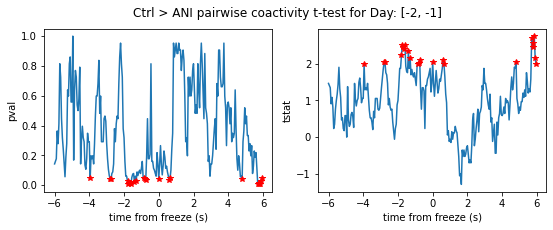

In [541]:
# Test code to build up stats for between group comparisons
times_use = np.unique(ctrl_df['time'])

# Get dataframes for each group on given day
# day_use = 2
day_use = [-2, -1]
if (type(day_use) == str) | (type(day_use) == int):
    ctrl_df_use = ctrl_df[ctrl_df['day'] == str(day_use)]
    ani_df_use = ani_df[ani_df['day'] == str(day_use)]
elif type(day_use) == list:
    ctrl_df_use = ctrl_df[(ctrl_df['day'] == str(day_use[0])) | (ctrl_df['day'] == str(day_use[1]))]
    ani_df_use = ani_df[(ani_df['day'] == str(day_use[0])) | (ani_df['day'] == str(day_use[1]))]

tstat_day, pval_day = [], []
for t in times_use:
    tstat, pval = stats.ranksums(ctrl_df_use[ctrl_df_use['time'] == t]['pw_co_prob'],
                                  ani_df_use[ani_df_use['time'] == t]['pw_co_prob'])
    tstat_day.append(tstat)
    pval_day.append(pval)

tstat_day = np.array(tstat_day)
pval_day = np.array(pval_day)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
fig.suptitle(f'Ctrl > ANI pairwise coactivity t-test for Day: {day_use}')
ax[0].plot(times_use, pval_day)
ax[0].plot(times_use[pval_day < 0.05], pval_day[pval_day < 0.05], 'r*')
ax[0].set_ylabel('pval')
ax[0].set_xlabel('time from freeze (s)')

ax[1].plot(times_use, tstat_day)
ax[1].plot(times_use[pval_day < 0.05], tstat_day[pval_day < 0.05], 'r*')
ax[1].set_ylabel('tstat')
ax[1].set_xlabel('time from freeze (s)')



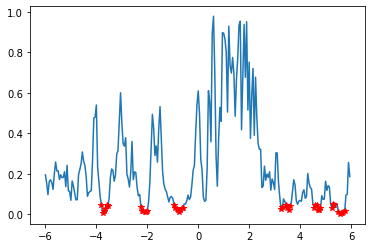

In [511]:
_, ax = plt.subplots()
ax.plot(times_use, pval_day)
ax.plot(times_use[pval_day < 0.05], pval_day[pval_day < 0.05], 'r*')

 Presentation notes: we noticed 
 1) that control animals developed heightened population activity prior to freezing 
 (PBE plots), suggesting population bursts, so we decided to investigate the tuning of individual cells, zooming
 into the 2 second period before freezing.  Suggests cells are "freeze-predicting"  
 2) discuss freeze-tuned cells, that  
 3) we confirmed had much more activity prior to freezing for Ctrl, but NOT
 ANI, as shown above in freeze-tuned cells plots, making them freeze-predicting cells.  
 4) Last, we confirmed that for Ctrl, but NOT ANI, these cells behaved as a cohesive unit after conditioning, per our covariance analysis and more fine-grained analysis above.

(-0.00030578054138322, 0.006421391369047619)

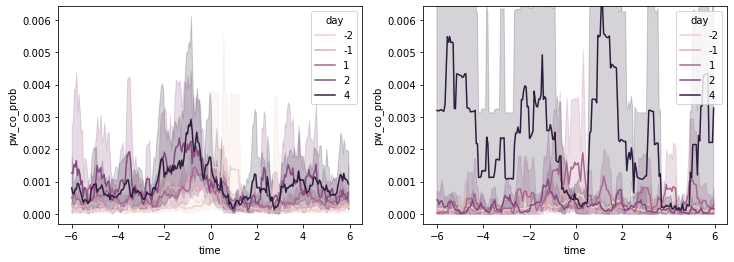

In [466]:
ctrl_df = coact_df_freeze2sec[(coact_df_freeze2sec['group'] == 'Learners') | 
                              (coact_df_freeze2sec['group'] == 'Non-learners')]
ani_df = coact_df_freeze2sec[coact_df_freeze2sec['group'] == 'ANI']
_, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=ctrl_df, x='time', y='pw_co_prob', hue='day', ax=ax[0])
sns.lineplot(data=ani_df, x='time', y='pw_co_prob', hue='day', ax=ax[1])
ax[1].set_ylim(ax[0].get_ylim())

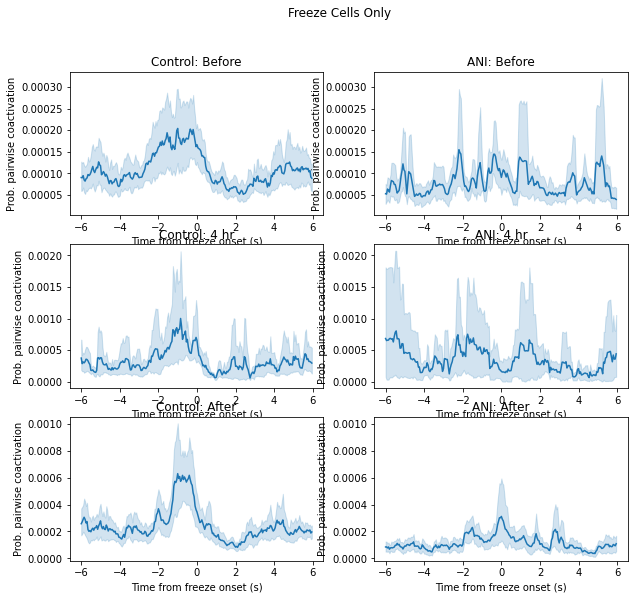

In [376]:
fig, ax = plot_pw_coactivity(coact_df_freeze6, groups=[['Learners', 'Non-learners'], ['ANI']], 
                             group_names=['Control', 'ANI'], fig_suptitle='Freeze Cells Only')

In [386]:
print(MD1.PSAbool[0].shape)
bin_size = 0.5
psabin = fa.bin_array(MD1.PSAbool[0], int(bin_size*MD1.sr_image))
print(psabin.shape)

(11991,)
(1200,)


In [392]:
pe_raster.shape

(490, 47, 240)

In [390]:
pe_raster_bin = MD1.gen_pe_rasters('freeze_onset', buffer_sec=(6, 6), bin_size=0.5)
pe_raster = MD1.gen_pe_rasters('freeze_onset', buffer_sec=(6, 6))

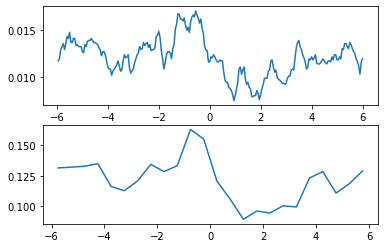

In [433]:
_, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(-5.95, 6.05, 0.05), pe_raster.mean(axis=0).mean(axis=0))
ax[1].plot(np.arange(-5.75, 6.25, 0.5), pe_raster_bin.mean(axis=0).mean(axis=0))


In [ ]:
# Would need to figure out timing for above - with half second bins I can't fudge things like you can with 0.05 sec bins.
# Would need to probably go from -5.75 to 5.75 - bins in the center of each time point. Keep consistent by doing the same
# with the 20 Hz sample rate data too


In [428]:
-6+23*0.5

5.5

In [425]:
pe_raster_bin.shape

(221, 42, 24)

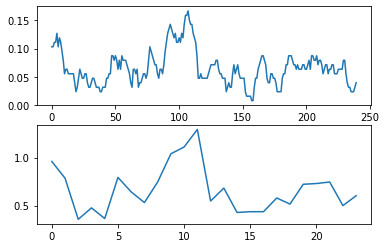

In [424]:
MD1 = fa.MotionTuning(err.learners[3], 'Shock', 2)
cells_to_use = MD1.get_sig_neurons(event_type, buffer_sec=(2, 2))
                    
pe_raster_bin = MD1.gen_pe_rasters('freeze_onset', buffer_sec=(6, 6), bin_size=0.5)
pe_raster = MD1.gen_pe_rasters('freeze_onset', buffer_sec=(6, 6))
_, ax = plt.subplots(2, 1)
ax[0].plot(pe_raster[cells_to_use].mean(axis=0).mean(axis=0))
ax[1].plot(pe_raster_bin[cells_to_use].mean(axis=0).mean(axis=0))

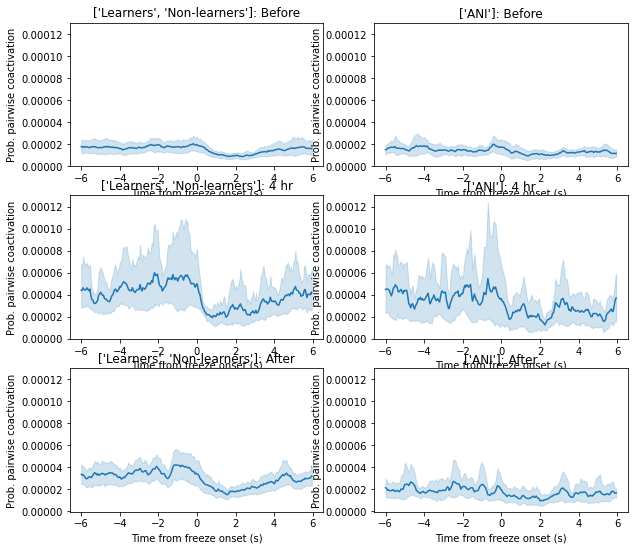

In [485]:
# plots for freeze cells
_, ax = plt.subplots(3, 2, figsize=(10, 9))
groups = [['Learners', 'Non-learners'], ['ANI']]
periods = ['Before', '4 hr', 'After']
days = [[-2, -1], [4], [1, 2]]
for arow, period, day_list in zip(ax, periods, days):
    day_bool = [coact_df_all['day'] == day for day in day_list]
    day_bool = np.bitwise_or(day_bool[0], day_bool[1]) if len(day_bool) == 2 else day_bool[0]
    df_use = coact_df_all[day_bool]
    for a, group in zip(arow, groups):
        group_bool = [df_use['group'] == grp for grp in group]
        group_bool = np.bitwise_or(group_bool[0], group_bool[1]) if len(group_bool) == 2 else group_bool[0]
        sns.lineplot(data=df_use[group_bool], x='time', y='pw_co_prob', ax=a)
        a.set_xlabel('Time from freeze onset (s)')
        a.set_ylabel('Prob. pairwise coactivation')
        a.set_title(f'{group}: {period}')
    
# Now match y-limits
ylims_use = (np.array([a.get_ylim() for a in ax.reshape(-1)]).reshape(-1).min(), 
            np.array([a.get_ylim() for a in ax.reshape(-1)]).reshape(-1).max())
[a.set_ylim(ylims_use) for a in ax.reshape(-1)];

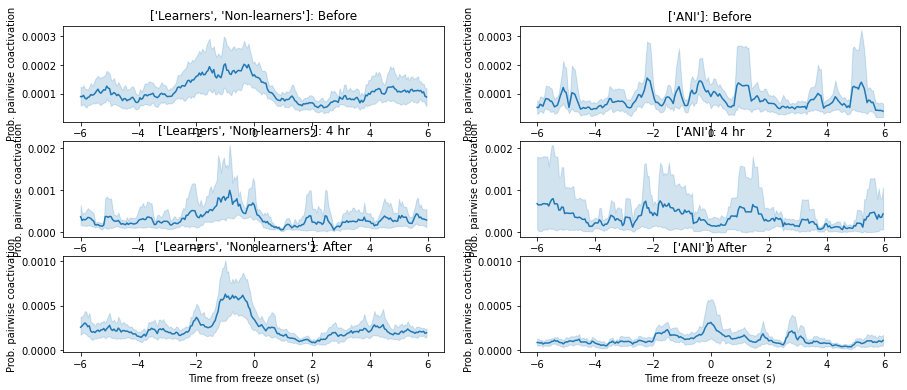

In [315]:
# plots for freeze cells
_, ax = plt.subplots(3, 2, figsize=(10, 9))
groups = [['Learners', 'Non-learners'], ['ANI']]
periods = ['Before', '4 hr', 'After']
days = [[-2, -1], [4], [1, 2]]
for arow, period, day_list in zip(ax, periods, days):
    day_bool = [coact_df_freeze['day'] == day for day in day_list]
    day_bool = np.bitwise_or(day_bool[0], day_bool[1]) if len(day_bool) == 2 else day_bool[0]
    df_use = coact_df_freeze[day_bool]
    for a, group in zip(arow, groups):
        group_bool = [df_use['group'] == grp for grp in group]
        group_bool = np.bitwise_or(group_bool[0], group_bool[1]) if len(group_bool) == 2 else group_bool[0]
        sns.lineplot(data=df_use[group_bool], x='time', y='pw_co_prob', ax=a)
        a.set_xlabel('Time from freeze onset (s)')
        a.set_ylabel('Prob. pairwise coactivation')
        a.set_title(f'{group}: {period}')
    
    # Now match y-limits
    ylims_use = (np.array([a.get_ylim() for a in arow]).reshape(-1).min(), 
                np.array([a.get_ylim() for a in arow]).reshape(-1).max())
    [a.set_ylim(ylims_use) for a in arow];

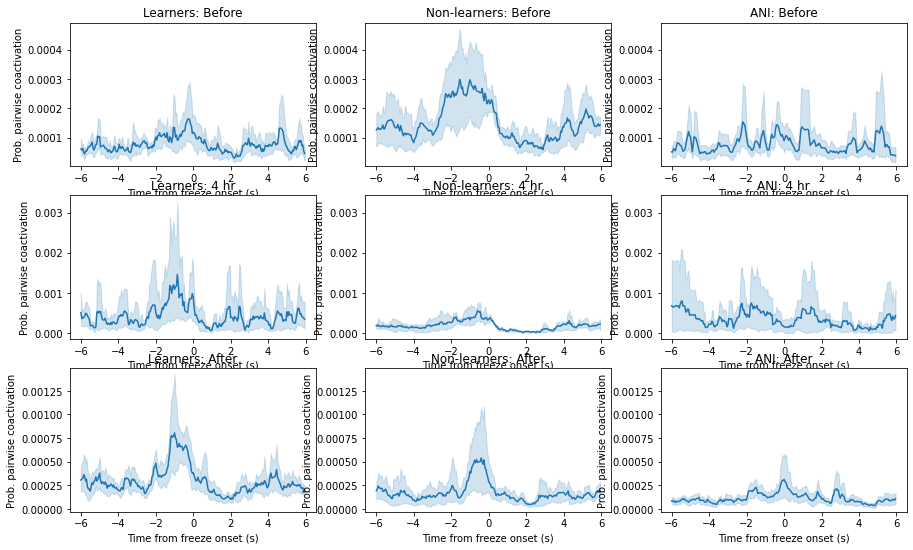

In [295]:
# plots for freeze cells
_, ax = plt.subplots(3, 3, figsize=(15, 9))
groups = ['Learners', 'Non-learners', 'ANI']
periods = ['Before', '4 hr', 'After']
days = [[-2, -1], [4], [1, 2]]
for arow, period, day_list in zip(ax, periods, days):
    day_bool = [coact_df_freeze['day'] == day for day in day_list]
    day_bool = np.bitwise_or(day_bool[0], day_bool[1]) if len(day_bool) == 2 else day_bool[0]
    df_use = coact_df_freeze[day_bool]
    for a, group in zip(arow, groups):
        group_bool = [coact_df_freeze['group'] == grp for grp in group]
        group_bool = np.bitwise_or(group_bool[0], group_bool[1]) if len(group_bool) == 2 else group_bool[0]
        sns.lineplot(data=df_use[group_bool], x='time', y='pw_co_prob', ax=a)
        a.set_xlabel('Time from freeze onset (s)')
        a.set_ylabel('Prob. pairwise coactivation')
        a.set_title(f'{group}: {period}')
    
    # Now match y-limits
    ylims_use = (np.array([a.get_ylim() for a in arow]).reshape(-1).min(), 
                np.array([a.get_ylim() for a in arow]).reshape(-1).max())
    [a.set_ylim(ylims_use) for a in arow];

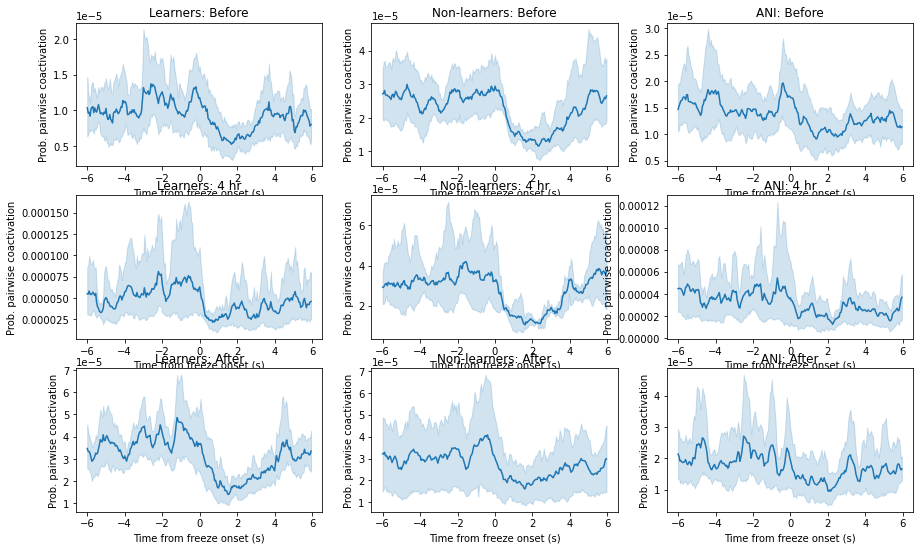

In [266]:
# Plots for all cells
_, ax = plt.subplots(3, 3, figsize=(15, 9))
groups = ['Learners', 'Non-learners', 'ANI']
periods = ['Before', '4 hr', 'After']
days = [[-2, -1], [4], [1, 2]]
for arow, period, day_list in zip(ax, periods, days):
    day_bool = [coact_df_all['day'] == day for day in day_list]
    day_bool = np.bitwise_or(day_bool[0], day_bool[1]) if len(day_bool) == 2 else day_bool[0]
    df_use = coact_df_all[day_bool]
    for a, group in zip(arow, groups):
        sns.lineplot(data=df_use[df_use['group'] == group], x='time', y='pw_co_prob', ax=a)
        a.set_xlabel('Time from freeze onset (s)')
        a.set_ylabel('Prob. pairwise coactivation')
        a.set_title(f'{group}: {period}')
        
    # Now match y-limits
    ylims_use = (np.array([a.get_ylim() for a in arow]).reshape(-1).min(), 
                np.array([a.get_ylim() for a in arow]).reshape(-1).max())
    [a.set_ylim(ylims_use) for a in arow];

In [ ]:
# Get pairwise coactivity.
# This takes a very long time! Lots of iterations! Maybe I can directly check bitwise and between rast1 and all the other rasters?
n = 1
pw_co_all = []
for rast1 in MD1.pe_rasters['freeze_onset'][:-1]:
    for rast2 in MD1.pe_rasters['freeze_onset'][n:]:
        pw_co = np.array([np.sum(np.bitwise_and(rast1, rast2), axis=0) for rast2 in MD1.pe_rasters['freeze_onset'][1:]])
        pw_co_all.append(pw_co)
        

In [486]:
def get_group_PBE_rasters(animal_list, group_name, buffer_sec=(6, 6), event_type='freeze_onset', sr_match=20):
    """Gets rasters of population level calcium activity centered on specified events default = freeze onset"""
    
    # Set up times for all PBE rasters
    times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
    
    nanimals = len(animal_list)
    PBEdict = {}
    for day in  [-2, -1, 4, 1, 2]:
        PBErast_comb, PBErast_combz, times_comb = [], [], []
        for animal in animal_list:
            MD1 = fa.MotionTuning(animal, 'Shock', day)
            PBErast = fa.get_PE_raster(MD1.PSAbool.sum(axis=0), MD1.select_events(event_type), 
                                       sr_image=MD1.sr_image, buffer_sec=buffer_sec)
            # Sum up cells active and divide by total to get proportion active before each event
            PBErast_prop = PBErast.mean(axis=0)/MD1.PSAbool.shape[0]
            
            # z-score proportions
            prop_active = MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0]
            PBErast_propz = (PBErast_prop - prop_active.mean())/prop_active.std()
        
            if MD1.sr_image != sr_match:  # interpolate values if sample rate doesn't match to make data compatible
                rast_mean_interp = []
                times_sr = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
                PBErast_comb.extend(np.interp(times, times_sr, PBErast_prop))
                PBErast_combz.extend(np.interp(times, times_sr, PBErast_propz))
            else:
                PBErast_comb.extend(PBErast_prop) 
                PBErast_combz.extend(PBErast_propz)
            times_comb.extend(times)  # aggregate times
            
        # Assemble into dataframes for easy plotting later on
        PBEdict[day] = pd.DataFrame({'times': np.array(times_comb).reshape(-1), 
                                     'act_neuron_ratio': np.array(PBErast_comb).reshape(-1),
                                     'act_neuron_ratio_z': np.array(PBErast_combz).reshape(-1),
                                     'group': [group_name]*len(np.array(times_comb).reshape(-1)),
                                     'day': [day]*len(np.array(times_comb).reshape(-1))})
        
    return PBEdict

In [487]:
from copy import copy
PBElearn = get_group_PBE_rasters(err.learners, 'Learners')
PBEnlearn = get_group_PBE_rasters(err.nonlearners, 'Non-Learners')
PBEani = get_group_PBE_rasters(err.ani_mice_good, 'ANI')
# PBEanisub = get_group_PBE_rasters(['Marble17', 'Marble18', 'Marble19', 'Marble25'])
control_mice_good = copy(err.learners)
control_mice_good.extend(err.nonlearners)
PBEctrl = get_group_PBE_rasters(control_mice_good, 'Control')

In [488]:
from copy import deepcopy

def add_memory_designations(df_use, before=[-2, -1], during=[4], after=[1, 2]):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df["day"] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df["day"] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df["day"] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
       # Old hardcoded method below for reference/bug checking
#     before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
#     during_ind = np.where(df["d1_d2"] == "4_1")[0]
#     after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

In [489]:
PBEcomb, PBEcomb_simp = {}, {}
for day in [-2, -1, 4, 1, 2]:
    PBEcomb[day] = pd.concat([PBElearn[day], PBEnlearn[day], PBEani[day]])
    PBEcomb_simp[day] = pd.concat([PBEctrl[day], PBEani[day]])

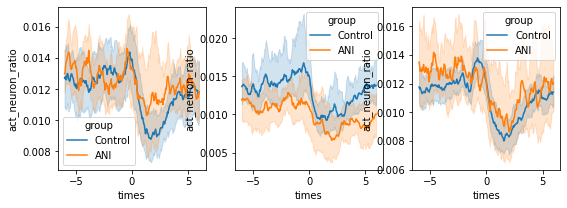

In [490]:
PBEcomb_simp2 = add_memory_designations(pd.concat(PBEcomb_simp.values()))
_, ax = plt.subplots(1, 3, figsize=(9, 3))
for a, desig in zip(ax, ['Before', '4hr', 'After']):
    sns.lineplot(data=PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig], 
                                    x='times', y='act_neuron_ratio', hue='group', ax=a)

In [ ]:
p_t, tstat_t = [], []
for timept in np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == 'After']['times']):
    time_bool = PBEcomb_simp2[PBEcomb_simp2['Designation'] == 'After']['times'] == timept
    df_tpt = PBEcomb_simp2[PBEcomb_simp2['Designation'] == 'After'][time_bool]
    control_bool = df_tpt['group'] == 'Control'
    ani_bool = df_tpt['group'] == 'ANI'
    tstat, p = stats.ttest_ind(df_tpt[control_bool]['act_neuron_ratio_z'],
                               df_tpt[ani_bool]['act_neuron_ratio_z'])
    p_t.append(p)
    tstat_t.append(tstat)
    

In [ ]:
_, ax = plt.subplots()

alpha = 0.05
times_plot = np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == 'After']['times'])
ax.plot(times_plot, tstat_t)
sigbool = np.array(p_t) < alpha
# ax.axhline(0.05, color='r')
ylim = ax.get_ylim()
ax.plot(times_plot[sigbool], np.ones(np.sum(sigbool))*ylim[1]*0.9, 'r*')

In [ ]:
PBEcomb_simp2

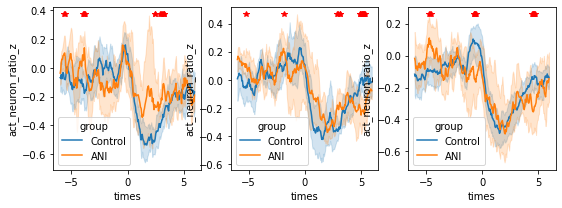

In [583]:
alpha = 0.05
PBEcomb_simp2 = add_memory_designations(pd.concat(PBEcomb_simp.values()))
_, ax = plt.subplots(1, 3, figsize=(9, 3))
for a, desig in zip(ax, ['Before', '4hr', 'After']):
    sns.lineplot(data=PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig], 
                                    x='times', y='act_neuron_ratio_z', hue='group', ax=a)
    
    # Get sig bins and plot
    p_t, tstat_t = [], []
    for timept in np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times']):
        time_bool = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'] == timept
        df_tpt = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig][time_bool]
        control_bool = df_tpt['group'] == 'Control'
        ani_bool = df_tpt['group'] == 'ANI'
        tstat, p = stats.ttest_ind(df_tpt[control_bool]['act_neuron_ratio_z'],
                                   df_tpt[ani_bool]['act_neuron_ratio_z'])
        p_t.append(p)
        tstat_t.append(tstat)
    
    # Plot sig

    times_plot = np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'])
    sigbool = np.array(p_t) < alpha
    ylim = a.get_ylim()
    a.plot(times_plot[sigbool], np.ones(np.sum(sigbool))*ylim[1]*0.9, 'r*')


In [ ]:
# Does the above come from individual cell responses averaged or synchronous events?
# 1) MUA raster
# 2) detect coactive points (discretize) and plot raster (PETH). Do stats - calc coactivity,
# then shuffle relative to events.
# 3) More extreme is to look at PBEs. High threshold for PBE. 30% of cells. Show raster with individual cells.

In [ ]:
def plot_group_PBE_rasters(PBEdict, group_name, ydata='act_neuron_ratio_z', days=[-2, -1, 4, 1, 2], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 5, figsize=(16, 4))
    for day, a in zip(days, ax.reshape(-1)):
        df_test = PBEdict[day]
        sns.lineplot(data=df_test, x='times', y=ydata, ax=a)
        a.set_xlabel('Time from freeze (s)')
        a.set_ylabel('Prop. neurons active')
        a.set_title(f'{group_name} Day {day}')
    

In [ ]:
%matplotlib inline
plot_group_PBE_rasters(PBElearn, 'Learners')
plot_group_PBE_rasters(PBEnlearn, 'Non-Learners')
plot_group_PBE_rasters(PBEani, 'ANI')
# plot_group_PBE_rasters(PBEanisub, 'ANIsubset')
plot_group_PBE_rasters(PBEctrl, 'Control')

In [ ]:
%matplotlib notebook
plot_group_PBE_rasters(PBEani, 'ANI')
# PBEani = get_group_PBE_rasters(['Marble17', 'Marble18', 'Marble19', 'Marble25'])

In [ ]:
pd.Series((PBErast_propz > SCEthresh).sum(axis=0)).rolling(3).mean()

In [ ]:
_, ax = plt.subplots()
ax.plot(pd.Series((PBErast_propz > SCEthresh).sum(axis=0)).rolling(10).mean())

In [ ]:
_, ax = plt.subplots()
sns.lineplot(data=pd.DataFrame(SCEsum[3]).rolling(window, axis=1, closed='both').mean().T, y=[0, 1, 2, 3], ax=ax)

In [ ]:
window=10
t = pd.DataFrame(SCEsum[3]).rolling(window, axis=1, center=True).mean().T
t.insert(4, "time", np.arange(-6, 6, 1/20), True)
tt = pd.DataFrame()
for i in range(4):
    temp = t.iloc[:, [i, 4]].rename(columns={i: "sce_prob"})
    tt = pd.concat((tt, temp), axis=0)

_, ax = plt.subplots()
sns.lineplot(data=tt, x="time", y="sce_prob", ax=ax)


In [ ]:
t = pd.DataFrame(SCEsum[3]).rolling(window, axis=1, closed='both').mean().T
t.insert(4, "time", np.arange(-6, 6, 1/20), True)
_, ax = plt.subplots()
sns.lineplot(data=t, x="time", ax=ax)
t
# t.pivot(columns=[0], index="time")
# _, ax = plt.subplots()
# sns.lineplot(data=t.unstack()

In [ ]:
window=10
_, ax = plt.subplots()
# sns.heatmap(pd.DataFrame(SCEsum[3]).rolling(window, axis=1, closed='both').mean(), ax=ax)
# ax.plot(pd.DataFrame(SCEsum[3]).rolling(window, axis=1, closed='both').mean().mean(axis=0))
sns.lineplot(data=pd.DataFrame(SCEsum[3]).rolling(window, axis=1, center=True).mean().T, ax=ax)

In [ ]:
_, ax = plt.subplots(1, 5, figsize=(12, 3))

for a, sce in zip(ax, SCEsum):
    

In [ ]:
np.array(SCEsum).shape

In [ ]:
# Plot PBE rasters for all animals
# Set up times for all PBE rasters
sr_match = 20
buffer_sec = (6, 6)
animal_list = err.learners
times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
SCEthresh = 3

nanimals = len(animal_list)
PBEdict = {}

_, ax = plt.subplots(nanimals, len([-2, -1, 4, 1, 2]), figsize=(12, 12))
_, ax2 = plt.subplots(nanimals, len([-2, -1, 4, 1, 2]), figsize=(12, 6))
SCEsum = []
for acol, acol2, day in zip(ax.T, ax2.T, [-2, -1, 4, 1, 2]):
    PBErast_comb, PBErast_combz, SCEsumtemp, times_comb = [], [], [], []
    for a, a2, animal in zip(acol, acol2, animal_list):
        # Set up times for all PBE rasters
        times = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
        MD1 = fa.MotionTuning(animal, 'Shock', day)
        PBErast = fa.get_PE_raster(MD1.PSAbool.sum(axis=0), MD1.select_events(event_type), 
                                   sr_image=MD1.sr_image, buffer_sec=buffer_sec)
        
        # Sum up cells active and divide by total to get proportion active before each event
        PBErast_prop = PBErast/MD1.PSAbool.shape[0]

        # z-score proportions
        prop_active = MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0]
        PBErast_propz = (PBErast_prop - prop_active.mean())/prop_active.std()
        sns.heatmap(PBErast_propz > SCEthresh, ax=a)
        a.set_xticks([0, int(len(times)/2), len(times)])
        a.set_xticklabels([-buffer_sec[0], 0, buffer_sec[1]])
        SCEsumtemp.append((PBErast_propz > SCEthresh).mean(axis=0))
        
        a2.plot(times, (PBErast_propz > SCEthresh).sum(axis=0))
        a2.set_xlim([-6, 6])
    SCEsum.append(np.array(SCEsumtemp))
        

In [ ]:
# plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
# Fig3a.savefig(plot_path / 'Figure3a.pdf', scriptname='Figure3a.ipynb')
# Fig3astats.savefig(plot_path / 'Figure3stats.pdf', scriptname='Figure3a.ipynb')